# Programming for Data Analytics Project
# Analysis of Wind Speed Data

*Author: Eoghan Walsh*
***

## Short Desciption

## Import Modules

In [535]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import AutoMinorLocator
import seaborn as sns
import csv
import re
import requests
from io import StringIO
import geopandas as gpd
from shapely.geometry import Point

## Import and Clean the Monthly Windspeed Data

In [536]:
# Function to import and clean the monthly weather date.
def import_monthly_data():

    # File containing csv URLs.
    txt_file = "./data/download-file-list-monthly.txt"

    # Regex pattern to find the start of useful data in CSV files.
    regex = r"^year(?!:)"

    # Columns to import to dataframe.
    columns = ["year","month", "wdsp"]

    # Numeric columns.
    numeric_columns = ["wdsp"]

    # List to store the dataframes.
    dataframes = []

    # Regex pattern to find the column header row in CSV files.
    regex_pattern = re.compile(regex, re.IGNORECASE)

    # Read the URLs from the txt file and strip newlines.
    with open(txt_file) as f:
        csv_urls = [line.strip() for line in f if line.strip()]

    # Loop through the URLs.
    for url in csv_urls:
        try:
            # Send GET request to the URL.
            response = requests.get(url)
            if response.status_code != 200:
                print(f"Failed to retrieve the CSV file. Status code: {response.status_code}")
                continue

            # Treat response content as file-like object.
            csv_content = response.text
            csv_file = StringIO(csv_content)

            # Find the row with column headers.
            csv_reader = csv.reader(csv_file)

            station_name = ",".join(next(csv_reader)).split("Station Name: ")[1].lower().replace(" ", "_")

            for row_number, row in enumerate(csv_reader):
                row_string = ",".join(row)
                if regex_pattern.search(row_string):
                    break
            else:
                print(f"Error finding regex pattern: \"{regex_pattern.pattern}\" in {url}")
                continue

            # Reset the file pointer and import the data to DataFrame.
            csv_file.seek(0)
            df = pd.read_csv(csv_file, skiprows=row_number, usecols=columns)

            # Add new date column.
            df['date'] = pd.to_datetime(df['year'].astype(str) + '-' + df['month'].astype(str))
            
            # Set date column as index.
            df = df.set_index('date')

            # Drop year and month columns.
            df = df.drop(columns=['year', 'month'])

            # Convert data to numeric.
            for col in numeric_columns:
                df[col] = pd.to_numeric(df[col], errors="coerce")

            # Replace any blanks with NAs.
            df = df.replace(" ", np.nan)

            # Update column names to include station name.
            df.columns = [f"{station_name}"]

            # Append dataframes to list.
            dataframes.append(df)

            print(f"Imported {url} as {station_name}")

        except Exception as e:
            print(f"An error occurred while processing {url} ({station_name}): {e}")

    return dataframes


# Call the function.
dataframes = import_monthly_data()

Imported https://cli.fusio.net/cli/climate_data/webdata/mly1875.csv as athenry
Imported https://cli.fusio.net/cli/climate_data/webdata/mly675.csv as ballyhaise
Imported https://cli.fusio.net/cli/climate_data/webdata/mly2375.csv as belmullet
Imported https://cli.fusio.net/cli/climate_data/webdata/mly3723.csv as casement
Imported https://cli.fusio.net/cli/climate_data/webdata/mly2175.csv as claremorris
Imported https://cli.fusio.net/cli/climate_data/webdata/mly3904.csv as cork_airport
Imported https://cli.fusio.net/cli/climate_data/webdata/mly532.csv as dublin_airport
Imported https://cli.fusio.net/cli/climate_data/webdata/mly1375.csv as dunsany
Imported https://cli.fusio.net/cli/climate_data/webdata/mly2075.csv as finner
Imported https://cli.fusio.net/cli/climate_data/webdata/mly1475.csv as gurteen
Imported https://cli.fusio.net/cli/climate_data/webdata/mly1775.csv as johnstown_castle_2
Imported https://cli.fusio.net/cli/climate_data/webdata/mly4935.csv as knock_airport
Imported https:/

In [537]:
# Combine into one dataframe and normalize based on the date index.
# https://pandas.pydata.org/docs/reference/api/pandas.concat.html#pandas-concat
monthly_df = pd.concat(dataframes, axis=1, join='inner')

# Let's take a look.
monthly_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 158 entries, 2011-02-01 to 2024-11-01
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   athenry               158 non-null    float64
 1   ballyhaise            157 non-null    float64
 2   belmullet             158 non-null    float64
 3   casement              158 non-null    float64
 4   claremorris           153 non-null    float64
 5   cork_airport          158 non-null    float64
 6   dublin_airport        158 non-null    float64
 7   dunsany               158 non-null    float64
 8   finner                158 non-null    float64
 9   gurteen               157 non-null    float64
 10  johnstown_castle_2    157 non-null    float64
 11  knock_airport         158 non-null    float64
 12  mace_head             157 non-null    float64
 13  malin_head            157 non-null    float64
 14  markree               0 non-null      float64
 15  moor

In [538]:
# Drop markee and pheonix park as no wind speed data.
monthly_df = monthly_df.drop(columns=['markree', 'phoenix_park'])

## Plot the Wind Speed Data

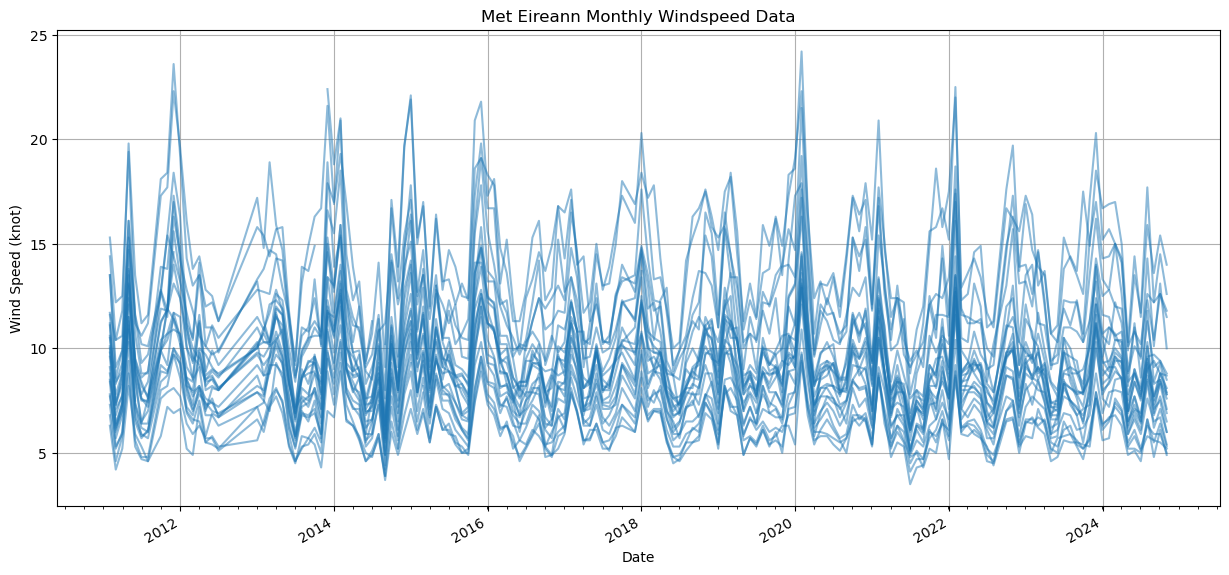

In [539]:
# Plot
fig, ax = plt.subplots(figsize=(15, 7))

# Plot dataframe.
ax.plot(monthly_df, alpha=0.5, color='tab:blue')

locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_minor_locator(AutoMinorLocator(8))
fig.autofmt_xdate()

ax.set_ylabel("Wind Speed (knot)")
ax.set_xlabel('Date')

ax.grid(True)

ax.set_title("Met Eireann Monthly Windspeed Data")

plt.show()

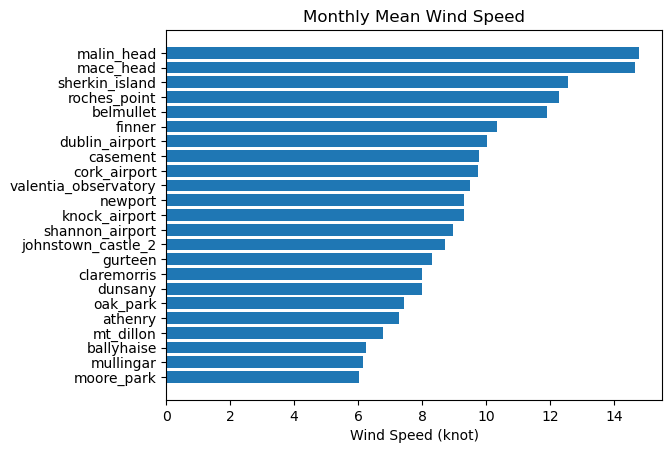

In [540]:
windspeed = monthly_df.mean().sort_values(ascending=True)

fig, ax = plt.subplots()

ax.barh(windspeed.index, windspeed)

ax.set_title("Monthly Mean Wind Speed")
ax.set_xlabel("Wind Speed (knot)")
#ax.set_ylabel("Met Eireann Synoptic Weather Stations")
plt.show()

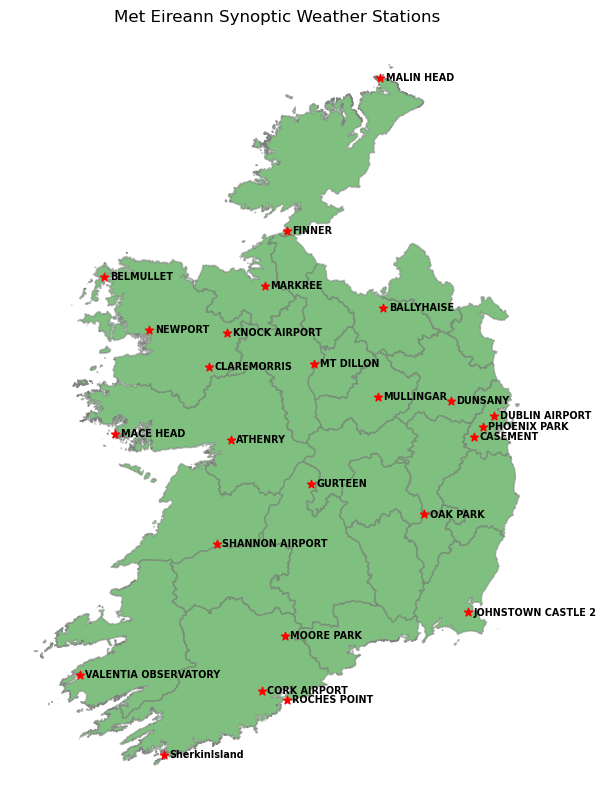

In [541]:
# Run map.py to show the location of weather stations.
%run ./map.py

Correlation: -0.12605193644454837


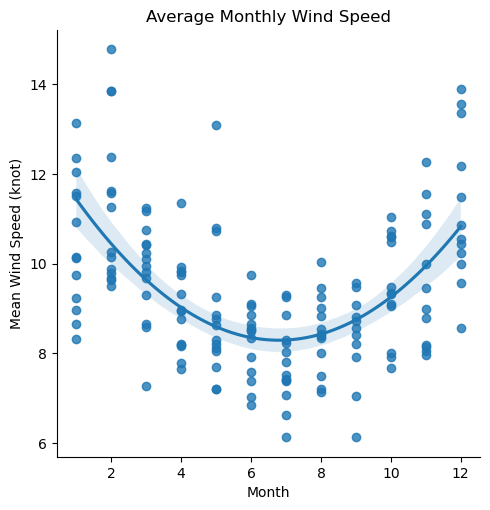

In [542]:
# Let's check if any correlation between the month the windspeed.

# Create new dataframe with month and mean wind speed.
monthly_mean = pd.DataFrame(monthly_df.mean(axis=1), columns=['wdsp'])
monthly_mean['month'] = monthly_mean.index.month

# Correlation between wind speed and month.
corr_windspeed = monthly_mean["month"].corr(monthly_mean["wdsp"])
print(f'Correlation: {corr_windspeed}')

# Plot the monthly wind speed and add a regression line.
title = "Average Monthly Wind Speed"
xlabel = "Month"
ylabel = "Mean Wind Speed (knot)"

sns.lmplot(data=monthly_mean, x='month', y='wdsp', order=2).set(title=title, xlabel=xlabel, ylabel=ylabel)

plt.show()

In [543]:
# Let's look at data on electricity generation from wind.
# https://www.seai.ie/data-and-insights/seai-statistics/monthly-energy-data/electricity-monthly#comp000064913259000000056f1221
seai_csv = "./data/seai_wind_gen_data.csv"
seai_df = pd.read_csv(seai_csv)
seai_df.head()

,Month of Period,Generation Source,Unit,Year of Period,Aggregation,Emission / Energy,Generated
0,January 2010,Wind,GWh,2010,Indig. Product.,Energy,248.002
1,February 2010,Wind,GWh,2010,Indig. Product.,Energy,150.952
2,March 2010,Wind,GWh,2010,Indig. Product.,Energy,251.394
3,April 2010,Wind,GWh,2010,Indig. Product.,Energy,186.269
4,May 2010,Wind,GWh,2010,Indig. Product.,Energy,168.528


In [544]:
# Let's clean the data.

# Add datetime column
seai_df['date'] = pd.to_datetime(seai_df['Month of Period'], format="%B %Y")


In [545]:
# Set datetime as index.
seai_df = seai_df.set_index('date')

In [546]:
# Add month column.
seai_df['month'] = seai_df.index.month

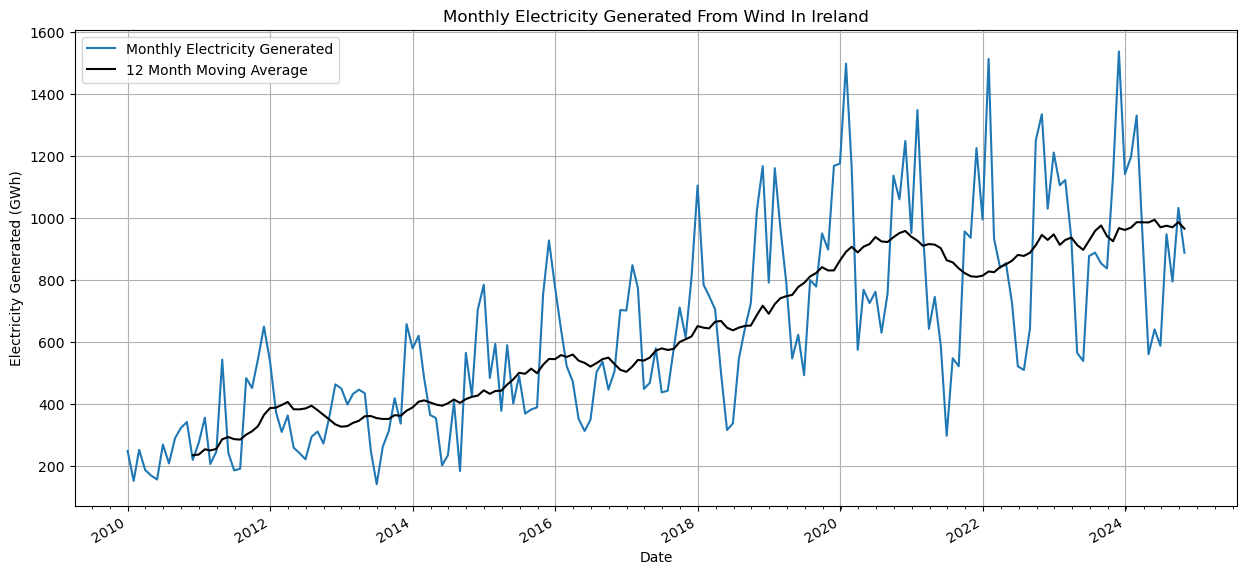

In [547]:
# Plot.
fig, ax = plt.subplots(figsize=(15, 7))

# Plot dataframe.
ax.plot(seai_df['Generated'], color='tab:blue', label='Monthly Electricity Generated')

# Add 12 month moving aveage to plot.
x = seai_df['Generated'].rolling(window=12).mean()

ax.plot(x, color='black', label='12 Month Moving Average')

locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_minor_locator(AutoMinorLocator(8))
fig.autofmt_xdate()

ax.set_ylabel("Electricity Generated (GWh)")
ax.set_xlabel('Date')

ax.grid(True)

ax.set_title("Monthly Electricity Generated From Wind In Ireland")

ax.legend()

plt.show()

Correlation: -0.0017869110205504535


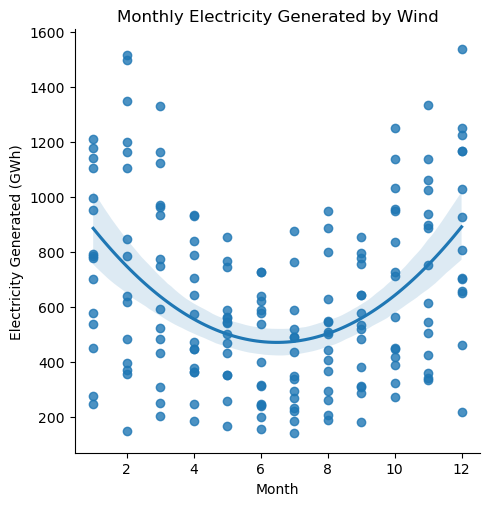

In [548]:
# Let's check if any correlation between the month and the electricity generated.

# Correlation between electricity generated and month.
corr_elec_gen = seai_df['month'].corr(seai_df['Generated'])
print(f'Correlation: {corr_elec_gen}')

# Plot the monthly wind speed and add a regression line.
title = "Monthly Electricity Generated by Wind"
xlabel = "Month"
ylabel = "Electricity Generated (GWh)"

sns.lmplot(data=seai_df, x='month', y='Generated', order=2).set(title=title, xlabel=xlabel, ylabel=ylabel)

plt.show()

In [549]:
# More wind gen data from eirgrid.
# https://www.eirgrid.ie/grid/system-and-renewable-data-reports
eirgrid_csv = './data/eirgrid_wind_gen_data.csv'

eirgrid_df = pd.read_csv(eirgrid_csv)
eirgrid_df.head()

,DateTime,IE Generation,IE Demand,IE Wind Availability,IE Wind Generation
0,01/01/2014 00:00,2752.48,2898.72,1053.11,1020.23
1,01/01/2014 00:15,2733.59,2868.97,1021.59,995.07
2,01/01/2014 00:30,2686.17,2826.42,972.06,932.71
3,01/01/2014 00:45,2657.56,2786.94,985.81,959.06
4,01/01/2014 01:00,2584.65,2723.94,958.63,920.82


In [550]:
# Let's clean the data.

# Add datetime column
eirgrid_df['date'] = pd.to_datetime(eirgrid_df['DateTime'], format="%d/%m/%Y %H:%M")

In [551]:
# Set datetime as index.
eirgrid_df = eirgrid_df.set_index('date')

In [552]:
# Let's drop the DateTime column.
eirgrid_df = eirgrid_df.drop(columns='DateTime')

In [553]:
# Let's add a month and an hour column.
eirgrid_df['month'] = eirgrid_df.index.month
eirgrid_df['hour'] = eirgrid_df.index.hour

In [554]:
eirgrid_df.head()

,IE Generation,IE Demand,IE Wind Availability,IE Wind Generation,month,hour
date,,,,,,
2014-01-01 00:00:00,2752.48,2898.72,1053.11,1020.23,1,0
2014-01-01 00:15:00,2733.59,2868.97,1021.59,995.07,1,0
2014-01-01 00:30:00,2686.17,2826.42,972.06,932.71,1,0
2014-01-01 00:45:00,2657.56,2786.94,985.81,959.06,1,0
2014-01-01 01:00:00,2584.65,2723.94,958.63,920.82,1,1


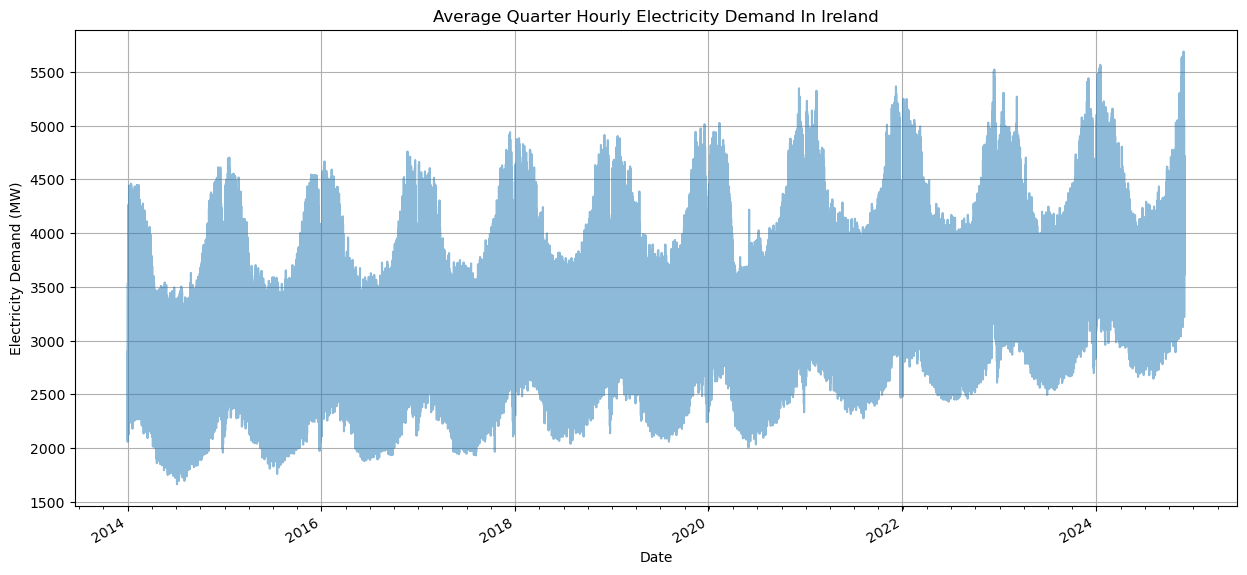

In [555]:
# Plot.
fig, ax = plt.subplots(figsize=(15, 7))

# Plot dataframe.
ax.plot(eirgrid_df['IE Demand'], color='tab:blue', alpha=0.5)

locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_minor_locator(AutoMinorLocator(8))
fig.autofmt_xdate()

ax.set_ylabel("Electricity Demand (MW)")
ax.set_xlabel('Date')

ax.grid(True)

ax.set_title("Average Quarter Hourly Electricity Demand In Ireland")

plt.show()

Correlation: -0.049229804544632126


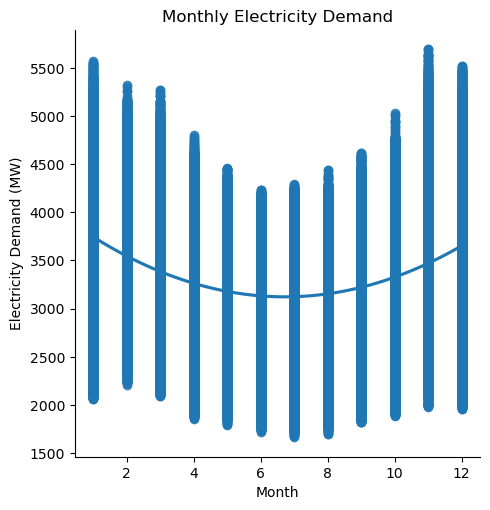

In [556]:
# Let's check if any correlation between the month and the electricity demand.

# Correlation between electricity generated and month.
corr_elec_dem = eirgrid_df['month'].corr(eirgrid_df['IE Demand'])
print(f'Correlation: {corr_elec_dem}')

# Plot the monthly wind speed and add a regression line.
title = "Monthly Electricity Demand"
xlabel = "Month"
ylabel = "Electricity Demand (MW)"

sns.lmplot(data=eirgrid_df, x='month', y='IE Demand', order=2).set(title=title, xlabel=xlabel, ylabel=ylabel)

plt.show()

Correlation: 0.5165410896594776


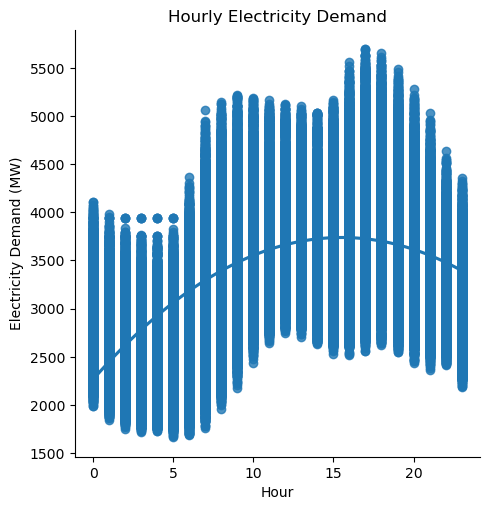

In [557]:
# Let's check if any correlation between the hour and the electricity demand.

# Correlation between electricity generated and hour.
corr_elec_hour = eirgrid_df['hour'].corr(eirgrid_df['IE Demand'])
print(f'Correlation: {corr_elec_hour}')

# Plot the monthly wind speed and add a regression line.
title = "Hourly Electricity Demand"
xlabel = "Hour"
ylabel = "Electricity Demand (MW)"

sns.lmplot(data=eirgrid_df, x='hour', y='IE Demand', order=2).set(title=title, xlabel=xlabel, ylabel=ylabel)

plt.show()